In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import *
from sklearn.cluster import KMeans
import koreanize_matplotlib
from sklearn.cluster import DBSCAN

from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, save_model, load_model

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import re

# 1. 데이터 추가 확보 

In [5]:
df_finished=pd.read_csv("../1월 프로젝트/완결 웹툰 목록.csv", index_col="Unnamed: 0")
df_finished['웹툰 관심수']=[int(re.sub(r',',"",x)) if x!="성인웹툰" else 0 for x in df_finished['웹툰 관심수']]
df_finished=df_finished[df_finished['웹툰 관심수']>10000].sort_values("웹툰 관심수",ascending=False).reset_index(drop=False)
df_finished.rename(columns = {'index' : '조회수 순위'}, inplace = True)

driver =webdriver.Chrome()
episode_list=[]
origin_list=[]
i=0
for url in df_finished['웹툰 링크'] : #요일별 웹툰 url
    i+=1
    driver.get(url)
    time.sleep(3) #웹 페이지가 열릴 때까지 대기
    role_list=[]
    try:
        epsiode = driver.find_element(By.CLASS_NAME,'EpisodeListView__count--fTMc5')
        writers=driver.find_elements(By.CLASS_NAME,'ContentMetaInfo__category--WwrCp')
        episode_list.append(epsiode.text[1:-1].lstrip())
        print(f'화수수집완료 {i}/{len(df_finished)}:{epsiode.text[1:-1].lstrip()}')
        for writer in writers:
            role=writer.text.split('∙')
            role_list.append(role[-1])
            print(role[-1])
        if '\n원작' in role_list:
            origin_list.append(1)
            print(f'원작가 존재 {i}/{len(df_finished)}:{role}')
        else:
            origin_list.append(0)
            print(f'원작가 없음 {i}/{len(df_finished)}')
    except: 
        print('성인웹툰 이슈')
        episode_list.append('성인웹툰')
        origin_list.append('성인웹툰')
        continue
    time.sleep(1)
driver.close()

df_finished['회차']=episode_list
df_finished['원작 유무']=origin_list

화수수집완료 1/1964:442

글/그림
원작가 없음 1/1964
화수수집완료 2/1964:1238

글/그림
원작가 없음 2/1964
화수수집완료 3/1964:516

글/그림
원작가 없음 3/1964
화수수집완료 4/1964:545

글

그림
원작가 없음 4/1964
화수수집완료 5/1964:573

글/그림
원작가 없음 5/1964
화수수집완료 6/1964:512

글/그림
원작가 없음 6/1964
화수수집완료 7/1964:261

글/그림
원작가 없음 7/1964
화수수집완료 8/1964:8

글/그림
원작가 없음 8/1964
화수수집완료 9/1964:223

글

그림
원작가 없음 9/1964
화수수집완료 10/1964:115

글/그림
원작가 없음 10/1964
화수수집완료 11/1964:159

글/그림
원작가 없음 11/1964
화수수집완료 12/1964:401

글/그림
원작가 없음 12/1964
화수수집완료 13/1964:355

글/그림
원작가 없음 13/1964
화수수집완료 14/1964:141

글

그림
원작가 없음 14/1964
화수수집완료 15/1964:372

글/그림
원작가 없음 15/1964
화수수집완료 16/1964:262

글

그림
원작가 없음 16/1964
화수수집완료 17/1964:236

글

그림
원작가 없음 17/1964
화수수집완료 18/1964:110

글

그림
원작가 없음 18/1964
화수수집완료 19/1964:413

글/그림
원작가 없음 19/1964
화수수집완료 20/1964:134

글/그림
원작가 없음 20/1964
화수수집완료 21/1964:93

글/그림
원작가 없음 21/1964
화수수집완료 22/1964:206

글/그림
원작가 없음 22/1964
화수수집완료 23/1964:445

글

그림
원작가 없음 23/1964
화수수집완료 24/1964:719

글

그림
원작가 없음 24/1964
화수수집완료 25/1964:130

글

그림
원작가 없음 25/1964
화수수집완료 26/1

In [236]:
df_current=pd.read_csv("../1월 프로젝트/연재중 웹툰 데이터_최종.csv", index_col="Unnamed: 0")
df_finished[['웹툰 이름','웹툰 별점','장르','웹툰 관심수','조회수 순위','회차','원작 유무']]

,웹툰 이름,웹툰 별점,장르,웹툰 관심수,조회수 순위,회차,원작 유무
0,연애혁명,9.87,드라마,2622242,20,442,0
1,마음의소리,9.86,개그,1750053,100,1238,0
2,프리드로우,9.79,드라마,1575709,67,516,0
3,노블레스,9.62,판타지,1371554,89,545,0
4,갓 오브 하이스쿨,9.64,판타지,1371113,48,573,0
...,...,...,...,...,...,...,...
1959,실버 쥬얼,9.80,판타지,10311,1958,67,0
1960,봉이 김선달,9.84,무협/사극,10250,1988,40,0
1961,38의 살인,9.84,스릴러,10131,2242,50,0
1962,한국만화 1990,9.75,일상,10073,1002,20,0


# 2. 데이터 전처리 (피쳐 수정,PCA)

### 2-0. 자료형 전처리

In [237]:
df_current['웹툰 관심수']=[int(re.sub(r',',"",x)) if x!="성인웹툰" else None for x in df_current['웹툰 관심수']]
df_current.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 0 to 693
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   웹툰 이름   694 non-null    object 
 1   웹툰 별점   694 non-null    float64
 2   웹툰 링크   694 non-null    object 
 3   연재 요일   694 non-null    object 
 4   장르      694 non-null    object 
 5   웹툰 관심수  667 non-null    float64
 6   요일별 순위  694 non-null    int64  
 7   회차      694 non-null    object 
 8   원작 유무   694 non-null    int64  
 9   작가이름    694 non-null    object 
 10  작품 수    694 non-null    float64
 11  전작 유무   694 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 70.5+ KB


In [238]:
df_current['웹툰 관심수'].fillna(round(df_current['웹툰 관심수'].median(),0),inplace=True) # 관심수의 중간값으로 결측치를 채움움
df_current

,웹툰 이름,웹툰 별점,웹툰 링크,연재 요일,장르,웹툰 관심수,요일별 순위,회차,원작 유무,작가이름,작품 수,전작 유무
0,참교육,9.89,https://comic.naver.com/webtoon/list?titleId=7...,mon,액션,952557.0,1,179,0,"['한가람', '채용택']",2.500000,1.0
1,환생천마,9.95,https://comic.naver.com/webtoon/list?titleId=8...,mon,무협/사극,153632.0,2,52,1,"['부겸', '장영훈', 'JP']",4.333333,1.0
2,똑 닮은 딸,9.98,https://comic.naver.com/webtoon/list?titleId=7...,mon,스릴러,673334.0,3,142,0,['이담'],1.000000,0.0
3,신의 탑,9.84,https://comic.naver.com/webtoon/list?titleId=1...,mon,판타지,1909208.0,4,653,0,['SIU'],1.000000,0.0
4,어느날 갑자기 가슴이 커짐,9.81,https://comic.naver.com/webtoon/list?titleId=8...,mon,일상,70824.0,5,25,0,['물렁이'],1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
689,밤필드의 아이들 by DARK MOON,9.84,https://comic.naver.com/webtoon/list?titleId=8...,sun,판타지,49934.0,91,48,0,['HYBE'],7.000000,1.0
690,노래 못 하는 남자,9.92,https://comic.naver.com/webtoon/list?titleId=8...,sun,로맨스,22545.0,92,57,0,"['재은', '이해금']",1.000000,0.0
691,마섹남 - 마술하는 섹시한 남자,9.89,https://comic.naver.com/webtoon/list?titleId=7...,sun,로맨스,54426.0,93,90,1,"['랑또', '육시몬', '티르스']",4.000000,1.0
692,주인공의 주식을 팝니다,9.84,https://comic.naver.com/webtoon/list?titleId=8...,sun,로맨스,57199.0,94,96,1,"['목감기', '가얌', '50']",1.333333,1.0


In [239]:
df_current.groupby('연재 요일').count()['웹툰 관심수']

연재 요일
fri     94
mon    105
sat     92
sun     95
thu    102
tue    105
wed    101
Name: 웹툰 관심수, dtype: int64

In [240]:
day_dict=dict(df_current.groupby('연재 요일').sum()['웹툰 관심수'])
day_dict

{'fri': 15680929.0,
 'mon': 14501056.0,
 'sat': 10105755.0,
 'sun': 11207475.0,
 'thu': 11190438.0,
 'tue': 13221357.0,
 'wed': 15503427.0}

In [241]:
# 요일마다 웹툰 갯수가 다르기 때문에, 각각도 평균치로 채워넣어서 웹툰 갯수를 요일별로 같게 한다.


day_dict=dict(df_current.groupby('연재 요일').sum()['웹툰 관심수'])
for key in day_dict.keys():
    day_dict[key]+=round(df_current['웹툰 관심수'].mean(),0)*(max(df_current.groupby('연재 요일').count()['웹툰 관심수'])-df_current.groupby('연재 요일').count()['웹툰 관심수'][key])

day_dict

{'fri': 17129794.0,
 'mon': 14501056.0,
 'sat': 11818050.0,
 'sun': 12524625.0,
 'thu': 11585583.0,
 'tue': 13221357.0,
 'wed': 16030287.0}

### 2-1. 요일별 순위 flatten

In [242]:
# 같은 요일내 인기 작품이(높은 관심수) 많을 수록, 높은 순위에 오르기 어렵다는 판단.  그렇기에 관심수가 높은 요일에 더 높은 가중치를 두어 하나의 필드에 표현하고자 함.
day_dict=dict(df_current.groupby('연재 요일').sum()['웹툰 관심수'])
days=['mon','tue','wed','thu','fri','sat','sun']
weights={day: round(day_dict[day]/735,3)  for day in days} #735 전체 웹툰을 가장 많은 요일의 갯수로 평탄화했을 때 기준 수임.

# 모든 웹툰의 목록 생성
all_webtoons = []
for day in days:
    all_webtoons.extend(df_current[df_current['연재 요일']==day]['웹툰 이름'])

# 웹툰별 점수 초기화
scores = {webtoon: 0 for webtoon in all_webtoons}

# 요일별 순위 점수 계산 (높은 순위에 높은 점수)
for webtoon, rank, day in zip(df_current['웹툰 이름'],df_current['요일별 순위'],df_current['연재 요일']):    
    scores[webtoon] += (len(df_current[df_current['연재 요일']==day]) - rank + 1)*weights[day] # 높은 순위에 높은 점수 부여

# 점수 기준으로 정렬
sorted_webtoons = sorted(scores.items(), key=lambda x: x[1], reverse=True)

rank_dict ={}
print("최종 통합 순위:")
for i, (webtoon, score) in enumerate(sorted_webtoons, start=1):
    print(f"{i}. {webtoon} (점수: {score})")
    rank_dict[webtoon]=i

rank_dict


최종 통합 순위:
1. 화산귀환 (점수: 2130402.898)
2. 전지적 독자 시점 (점수: 2109309.8000000003)
3. 무직백수 계백순 (점수: 2088216.7020000003)
4. 참교육 (점수: 2071579.4400000002)
5. 자기 자? (점수: 2067123.6040000003)
6. 환생천마 (점수: 2051850.1120000002)
7. 썰:관계주의 (점수: 2046030.5060000003)
8. 똑 닮은 딸 (점수: 2032120.7840000002)
9. 운명을 보는 회사원 (점수: 2024937.4080000003)
10. 신의 탑 (점수: 2012391.4560000002)
11. 광마회귀 (점수: 2005452.1180000002)
12. 백XX (점수: 2003844.31)
13. 어느날 갑자기 가슴이 커짐 (점수: 1992662.128)
14. 외모지상주의 (점수: 1984117.5210000002)
15. 쌉초의 난 (점수: 1982751.212)
16. 절대검감 (점수: 1972932.8)
17. 역대급 영지 설계사 (점수: 1962782.924)
18. 캐슬2:만인지상 (점수: 1961658.114)
19. 노곤하개 쇼츠 (점수: 1953203.472)
20. 나 혼자 만렙 뉴비 (점수: 1941448.327)
21. 울어 봐, 빌어도 좋고 (점수: 1940565.016)
22. 윈드브레이커 (점수: 1933474.144)
23. 재혼 황후 (점수: 1920113.7300000002)
24. 일렉시드 (점수: 1919471.918)
25. 소녀의 세계 (점수: 1913744.816)
26. 사신 (점수: 1898779.1330000001)
27. 66666년 만에 환생한 흑마법사 (점수: 1898378.82)
28. 귀촌리 (점수: 1894015.4880000001)
29. 김부장 (점수: 1888765.3050000002)
30. 나 혼자 탑에서 농사 (점수: 1877444.536)
31. 조선왕조

{'화산귀환': 1,
 '전지적 독자 시점': 2,
 '무직백수 계백순': 3,
 '참교육': 4,
 '자기 자?': 5,
 '환생천마': 6,
 '썰:관계주의': 7,
 '똑 닮은 딸': 8,
 '운명을 보는 회사원': 9,
 '신의 탑': 10,
 '광마회귀': 11,
 '백XX': 12,
 '어느날 갑자기 가슴이 커짐': 13,
 '외모지상주의': 14,
 '쌉초의 난': 15,
 '절대검감': 16,
 '역대급 영지 설계사': 17,
 '캐슬2:만인지상': 18,
 '노곤하개 쇼츠': 19,
 '나 혼자 만렙 뉴비': 20,
 '울어 봐, 빌어도 좋고': 21,
 '윈드브레이커': 22,
 '재혼 황후': 23,
 '일렉시드': 24,
 '소녀의 세계': 25,
 '사신': 26,
 '66666년 만에 환생한 흑마법사': 27,
 '귀촌리': 28,
 '김부장': 29,
 '나 혼자 탑에서 농사': 30,
 '조선왕조실톡': 31,
 '퀘스트지상주의': 32,
 '낢이 사는 이야기 - 계속되는 미미한 인생': 33,
 '사천당가의 검신급 소가주가 되었다': 34,
 '어쩌다보니 천생연분': 35,
 '시한부 천재가 살아남는 법': 36,
 '괴력 난신': 37,
 '1등급 싸움과외': 38,
 '수상한 다이어트 클럽': 39,
 '좋아? 죽어!': 40,
 '1초': 41,
 '절대회귀': 42,
 '회귀한 공작가의 막내도련님은 암살자': 43,
 '천마는 조용히 살고싶다': 44,
 '천하제일 대사형': 45,
 '서울 자가에 대기업 다니는 김 부장 이야기': 46,
 '버림받은 왕녀의 은밀한 침실': 47,
 '별을 품은 소드마스터': 48,
 '데드퀸': 49,
 '귀혼': 50,
 '우아한 욕망': 51,
 '미래의 골동품 가게': 52,
 '로맨스 저주': 53,
 '신입사원 김철수': 54,
 '팔이피플': 55,
 '내 여자친구는': 56,
 'A.I. 닥터': 57,
 '마음의소리2': 58,
 '천재 타자가 강속구를 숨김': 59,
 '

In [243]:
rank_df=pd.DataFrame(rank_dict.values(),index=rank_dict.keys(),columns=['순위'])
rank_df.reset_index(drop=False,inplace=True)
rank_df.rename(columns={'index':'웹툰 이름'},inplace=True)
df_current_2 =pd.merge(df_current, rank_df , on='웹툰 이름', how='inner')
df_current_2

,웹툰 이름,웹툰 별점,웹툰 링크,연재 요일,장르,웹툰 관심수,요일별 순위,회차,원작 유무,작가이름,작품 수,전작 유무,순위
0,참교육,9.89,https://comic.naver.com/webtoon/list?titleId=7...,mon,액션,952557.0,1,179,0,"['한가람', '채용택']",2.500000,1.0,4
1,환생천마,9.95,https://comic.naver.com/webtoon/list?titleId=8...,mon,무협/사극,153632.0,2,52,1,"['부겸', '장영훈', 'JP']",4.333333,1.0,6
2,똑 닮은 딸,9.98,https://comic.naver.com/webtoon/list?titleId=7...,mon,스릴러,673334.0,3,142,0,['이담'],1.000000,0.0,8
3,신의 탑,9.84,https://comic.naver.com/webtoon/list?titleId=1...,mon,판타지,1909208.0,4,653,0,['SIU'],1.000000,0.0,10
4,어느날 갑자기 가슴이 커짐,9.81,https://comic.naver.com/webtoon/list?titleId=8...,mon,일상,70824.0,5,25,0,['물렁이'],1.000000,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,밤필드의 아이들 by DARK MOON,9.84,https://comic.naver.com/webtoon/list?titleId=8...,sun,판타지,49934.0,91,48,0,['HYBE'],7.000000,1.0,667
690,노래 못 하는 남자,9.92,https://comic.naver.com/webtoon/list?titleId=8...,sun,로맨스,22545.0,92,57,0,"['재은', '이해금']",1.000000,0.0,673
691,마섹남 - 마술하는 섹시한 남자,9.89,https://comic.naver.com/webtoon/list?titleId=7...,sun,로맨스,54426.0,93,90,1,"['랑또', '육시몬', '티르스']",4.000000,1.0,678
692,주인공의 주식을 팝니다,9.84,https://comic.naver.com/webtoon/list?titleId=8...,sun,로맨스,57199.0,94,96,1,"['목감기', '가얌', '50']",1.333333,1.0,685


### 2-2. 웹툰 관심수 / 회차 (회당 평균으로 변환)

In [244]:
df_current_2=df_current_2.drop(list(df_current_2[df_current_2['회차']=='성인웹툰'].index),axis=0)
df_current_2.reset_index(drop=True,inplace=True)
df_current_2['회차']=df_current_2['회차'].apply(lambda x: int(x))
df_current_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   웹툰 이름   646 non-null    object 
 1   웹툰 별점   646 non-null    float64
 2   웹툰 링크   646 non-null    object 
 3   연재 요일   646 non-null    object 
 4   장르      646 non-null    object 
 5   웹툰 관심수  646 non-null    float64
 6   요일별 순위  646 non-null    int64  
 7   회차      646 non-null    int64  
 8   원작 유무   646 non-null    int64  
 9   작가이름    646 non-null    object 
 10  작품 수    646 non-null    float64
 11  전작 유무   646 non-null    float64
 12  순위      646 non-null    int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 65.7+ KB


In [245]:
df_current_2['회당 평균 관심수']=df_current_2['웹툰 관심수']/df_current_2['회차']

In [246]:
df_finished['회차']=df_finished['회차'].apply(lambda x: int(x))
df_finished['회당 평균 관심수']=df_finished['웹툰 관심수']/df_finished['회차']
df_finished

,조회수 순위,웹툰 이름,웹툰 별점,웹툰 링크,장르,웹툰 관심수,회차,원작 유무,회당 평균 관심수,스케일링 순위
0,20,연애혁명,9.87,https://comic.naver.com/webtoon/list?titleId=5...,드라마,2622242,442,0,5932.674208,0.008598
1,100,마음의소리,9.86,https://comic.naver.com/webtoon/list?titleId=2...,개그,1750053,1238,0,1413.613086,0.042992
2,67,프리드로우,9.79,https://comic.naver.com/webtoon/list?titleId=5...,드라마,1575709,516,0,3053.699612,0.028805
3,89,노블레스,9.62,https://comic.naver.com/webtoon/list?titleId=2...,판타지,1371554,545,0,2516.612844,0.038263
4,48,갓 오브 하이스쿨,9.64,https://comic.naver.com/webtoon/list?titleId=3...,판타지,1371113,573,0,2392.867365,0.020636
...,...,...,...,...,...,...,...,...,...,...
1959,1958,실버 쥬얼,9.80,https://comic.naver.com/webtoon/list?titleId=7...,판타지,10311,67,0,153.895522,0.841788
1960,1988,봉이 김선달,9.84,https://comic.naver.com/webtoon/list?titleId=7...,무협/사극,10250,40,0,256.250000,0.854686
1961,2242,38의 살인,9.84,https://comic.naver.com/webtoon/list?titleId=7...,스릴러,10131,50,0,202.620000,0.963887
1962,1002,한국만화 1990,9.75,https://comic.naver.com/webtoon/list?titleId=7...,일상,10073,20,0,503.650000,0.430782


### 2-3. 순위 스케일링, 관심 수 스케일링

In [548]:
# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
sclaed_rank=mMscaler.fit_transform(np.array(df_finished['조회수 순위']).reshape(-1, 1))

# 스케일링 데이터 전환
df_finished['스케일링 순위']= (1-sclaed_rank)*1000

# MinMaxScaler 초기화 및 Fitting
mMscaler = MinMaxScaler()
sclaed_rank=mMscaler.fit_transform(np.array(df_current_2['순위']).reshape(-1, 1))

# 스케일링 데이터 전환
df_current_2['스케일링 순위']= (1-sclaed_rank)*1000

In [549]:
df_concated= pd.concat([df_finished,df_current_2])
df_concated

,조회수 순위,웹툰 이름,웹툰 별점,웹툰 링크,장르,웹툰 관심수,회차,원작 유무,회당 평균 관심수,스케일링 순위,연재 요일,요일별 순위,작가이름,작품 수,전작 유무,순위
0,20.0,연애혁명,9.87,https://comic.naver.com/webtoon/list?titleId=5...,드라마,2622242.0,442,0,5932.674208,991.401548,NaN,NaN,NaN,NaN,NaN,NaN
1,100.0,마음의소리,9.86,https://comic.naver.com/webtoon/list?titleId=2...,개그,1750053.0,1238,0,1413.613086,957.007739,NaN,NaN,NaN,NaN,NaN,NaN
2,67.0,프리드로우,9.79,https://comic.naver.com/webtoon/list?titleId=5...,드라마,1575709.0,516,0,3053.699612,971.195185,NaN,NaN,NaN,NaN,NaN,NaN
3,89.0,노블레스,9.62,https://comic.naver.com/webtoon/list?titleId=2...,판타지,1371554.0,545,0,2516.612844,961.736887,NaN,NaN,NaN,NaN,NaN,NaN
4,48.0,갓 오브 하이스쿨,9.64,https://comic.naver.com/webtoon/list?titleId=3...,판타지,1371113.0,573,0,2392.867365,979.363715,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,NaN,밤필드의 아이들 by DARK MOON,9.84,https://comic.naver.com/webtoon/list?titleId=8...,판타지,49934.0,48,0,1040.291667,38.961039,sun,91.0,['HYBE'],7.000000,1.0,667.0
642,NaN,노래 못 하는 남자,9.92,https://comic.naver.com/webtoon/list?titleId=8...,로맨스,22545.0,57,0,395.526316,30.303030,sun,92.0,"['재은', '이해금']",1.000000,0.0,673.0
643,NaN,마섹남 - 마술하는 섹시한 남자,9.89,https://comic.naver.com/webtoon/list?titleId=7...,로맨스,54426.0,90,1,604.733333,23.088023,sun,93.0,"['랑또', '육시몬', '티르스']",4.000000,1.0,678.0
644,NaN,주인공의 주식을 팝니다,9.84,https://comic.naver.com/webtoon/list?titleId=8...,로맨스,57199.0,96,1,595.822917,12.987013,sun,94.0,"['목감기', '가얌', '50']",1.333333,1.0,685.0


In [570]:
df_preprocessed=df_concated[df_concated['웹툰 관심수']<1500000]
df_preprocessed=df_preprocessed[df_preprocessed['웹툰 관심수']>15000]

In [588]:
# MinMaxScaler 초기화 및 Fitting
mMscaler = MinMaxScaler()
sclaed_like=mMscaler.fit_transform(np.array(df_preprocessed['웹툰 관심수']).reshape(-1, 1))

# 스케일링 데이터 전환
df_preprocessed['스케일링 관심수']= sclaed_like*10000
df_preprocessed=df_preprocessed[df_preprocessed['회차']>16]

In [589]:
df_preprocessed_2=df_preprocessed[df_preprocessed['회차']>16][['스케일링 순위','스케일링 관심수']]

### 2-4. 피쳐 엔지니어링

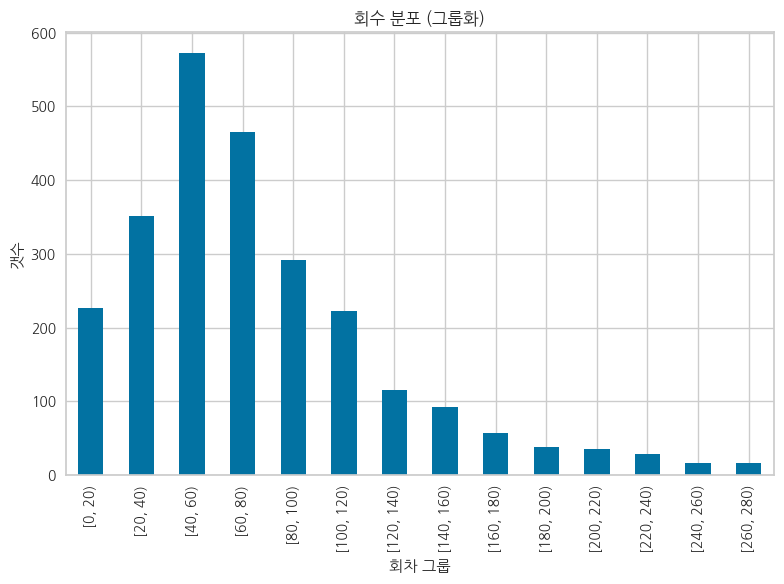

In [523]:
df_concated['회차그룹'] = pd.cut(df_concated['회차'], bins=range(0, 300, 20), right=False)

# 그룹별 갯수 계산
group_counts = df_concated.groupby('회차그룹').size()

# 시각화
plt.figure(figsize=(8, 6))
plt.title("회수 분포 (그룹화)")
group_counts.plot(kind='bar')
plt.xlabel('회차 그룹')
plt.ylabel('갯수')
plt.tight_layout()
plt.show()

In [524]:
df_concated['웹툰 관심수'].describe()

count    2.610000e+03
mean     1.220144e+05
std      1.757494e+05
min      1.613000e+03
25%      3.363450e+04
50%      6.690150e+04
75%      1.355968e+05
max      2.622242e+06
Name: 웹툰 관심수, dtype: float64

In [525]:
df_concated.sort_values("웹툰 관심수").tail(10)

,조회수 순위,웹툰 이름,웹툰 별점,웹툰 링크,장르,웹툰 관심수,회차,원작 유무,회당 평균 관심수,스케일링 순위,연재 요일,요일별 순위,작가이름,작품 수,전작 유무,순위,스케일링 관심수,회차그룹
6,270.0,여신강림,9.34,https://comic.naver.com/webtoon/list?titleId=7...,로맨스,1216760.0,261,0,4661.915709,883.920894,NaN,NaN,NaN,NaN,NaN,NaN,4636.852450,"[260.0, 280.0)"
5,28.0,유미의 세포들,9.93,https://comic.naver.com/webtoon/list?titleId=6...,로맨스,1285627.0,512,0,2510.990234,987.962167,NaN,NaN,NaN,NaN,NaN,NaN,4899.640506,NaN
4,48.0,갓 오브 하이스쿨,9.64,https://comic.naver.com/webtoon/list?titleId=3...,판타지,1371113.0,573,0,2392.867365,979.363715,NaN,NaN,NaN,NaN,NaN,NaN,5225.844635,NaN
3,89.0,노블레스,9.62,https://comic.naver.com/webtoon/list?titleId=2...,판타지,1371554.0,545,0,2516.612844,961.736887,NaN,NaN,NaN,NaN,NaN,NaN,5227.527437,NaN
196,NaN,화산귀환,9.87,https://comic.naver.com/webtoon/list?titleId=7...,무협/사극,1489716.0,153,1,9736.705882,1000.000000,wed,1.0,"['LICO', '비가']",13.5,1.0,1.0,5678.419189,"[140.0, 160.0)"
2,67.0,프리드로우,9.79,https://comic.naver.com/webtoon/list?titleId=5...,드라마,1575709.0,516,0,3053.699612,971.195185,NaN,NaN,NaN,NaN,NaN,NaN,6006.557968,NaN
1,100.0,마음의소리,9.86,https://comic.naver.com/webtoon/list?titleId=2...,개그,1750053.0,1238,0,1413.613086,957.007739,NaN,NaN,NaN,NaN,NaN,NaN,6671.833365,NaN
3,NaN,신의 탑,9.84,https://comic.naver.com/webtoon/list?titleId=1...,판타지,1909208.0,653,0,2923.748851,987.012987,mon,4.0,['SIU'],1.0,0.0,10.0,7279.149395,NaN
384,NaN,외모지상주의,9.45,https://comic.naver.com/webtoon/list?titleId=6...,드라마,2422324.0,537,0,4510.845438,981.240981,fri,2.0,['박태준'],6.0,1.0,14.0,9237.137344,NaN
0,20.0,연애혁명,9.87,https://comic.naver.com/webtoon/list?titleId=5...,드라마,2622242.0,442,0,5932.674208,991.401548,NaN,NaN,NaN,NaN,NaN,NaN,10000.000000,NaN


# 3. 클러스터링

### 3-1. 최적의 클러스터 갯수를 도출하기 위해 elbow point를 찾아보자.

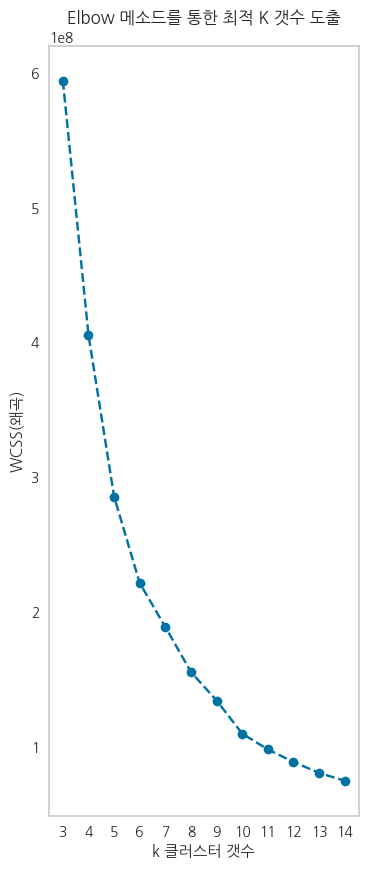

In [590]:
k_values = range(3, 15)

# WCSS 값을 저장할 리스트
wcss = []

# KMeans 반복 수행
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans.fit(df_preprocessed_2)
    wcss.append(kmeans.inertia_)  # WCSS 값 저장

# WCSS 시각화 (Elbow Plot)
plt.figure(figsize=(4, 10))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow 메소드를 통한 최적 K 갯수 도출')
plt.xlabel('k 클러스터 갯수')
plt.ylabel('WCSS(왜곡)')
plt.xticks(k_values)
plt.grid()
plt.show()

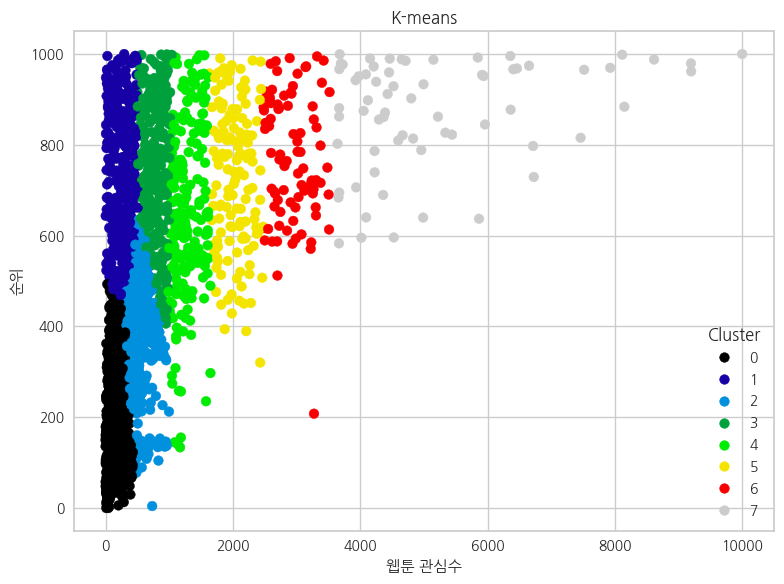

In [614]:
# k-mean


kmeans = KMeans(n_clusters=10, random_state=21)
kmeans.fit(df_preprocessed_2)

# k-means 클러스터링 결과 시각화 (8개)
plt.figure(figsize=(8, 6))
plt.title("K-means")
scatter=plt.scatter(df_preprocessed_2['스케일링 관심수'],df_preprocessed_2['스케일링 순위'], c=new_label_1)
plt.xlabel('웹툰 관심수')
plt.ylabel('순위')
plt.nipy_spectral()
# 레전드
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Cluster", loc='best')
plt.tight_layout()
plt.show()

### 3-2. k-means 성과지표 

In [609]:
labels = kmeans.labels_
silhouette = silhouette_score(df_preprocessed_2, labels)
print(f"Silhouette Score: {silhouette:.4f}")
davies_bouldin = davies_bouldin_score(df_preprocessed_2, labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
calinski_harabasz = calinski_harabasz_score(df_preprocessed_2, labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

Silhouette Score: 0.4249
Davies-Bouldin Index: 0.6814
Calinski-Harabasz Index: 6016.6807


In [610]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [594]:
df_preprocessed['정답 라벨링']=kmeans.labels_

In [611]:
new_label={6:7,2:7,7:7,0:6,9:5,3:4,5:3,1:2,8:1,4:0}
new_label_1 = [new_label[x] for x in df_preprocessed['정답 라벨링']]

In [612]:
new_label_1

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [613]:
df_preprocessed['정답 라벨링']=new_label_1

In [616]:
df_preprocessed.reset_index(drop=True, inplace=True)

In [621]:
df_preprocessed

,조회수 순위,웹툰 이름,웹툰 별점,웹툰 링크,장르,웹툰 관심수,회차,원작 유무,회당 평균 관심수,스케일링 순위,연재 요일,요일별 순위,작가이름,작품 수,전작 유무,순위,스케일링 관심수,정답 라벨링
0,89.0,노블레스,9.62,https://comic.naver.com/webtoon/list?titleId=2...,판타지,1371554.0,545,0,2516.612844,961.736887,NaN,NaN,NaN,NaN,NaN,NaN,9198.671890,7
1,48.0,갓 오브 하이스쿨,9.64,https://comic.naver.com/webtoon/list?titleId=3...,판타지,1371113.0,573,0,2392.867365,979.363715,NaN,NaN,NaN,NaN,NaN,NaN,9195.681202,7
2,28.0,유미의 세포들,9.93,https://comic.naver.com/webtoon/list?titleId=6...,로맨스,1285627.0,512,0,2510.990234,987.962167,NaN,NaN,NaN,NaN,NaN,NaN,8615.948845,7
3,270.0,여신강림,9.34,https://comic.naver.com/webtoon/list?titleId=7...,로맨스,1216760.0,261,0,4661.915709,883.920894,NaN,NaN,NaN,NaN,NaN,NaN,8148.919995,7
4,429.0,싸움독학,9.67,https://comic.naver.com/webtoon/list?titleId=7...,액션,1115468.0,223,0,5002.098655,815.563199,NaN,NaN,NaN,NaN,NaN,NaN,7461.997576,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,NaN,밤필드의 아이들 by DARK MOON,9.84,https://comic.naver.com/webtoon/list?titleId=8...,판타지,49934.0,48,0,1040.291667,38.961039,sun,91.0,['HYBE'],7.000000,1.0,667.0,235.965975,0
2247,NaN,노래 못 하는 남자,9.92,https://comic.naver.com/webtoon/list?titleId=8...,로맨스,22545.0,57,0,395.526316,30.303030,sun,92.0,"['재은', '이해금']",1.000000,0.0,673.0,50.224573,0
2248,NaN,마섹남 - 마술하는 섹시한 남자,9.89,https://comic.naver.com/webtoon/list?titleId=7...,로맨스,54426.0,90,1,604.733333,23.088023,sun,93.0,"['랑또', '육시몬', '티르스']",4.000000,1.0,678.0,266.428949,0
2249,NaN,주인공의 주식을 팝니다,9.84,https://comic.naver.com/webtoon/list?titleId=8...,로맨스,57199.0,96,1,595.822917,12.987013,sun,94.0,"['목감기', '가얌', '50']",1.333333,1.0,685.0,285.234342,0


In [628]:
df_preprocessed.columns

Index(['조회수 순위', '웹툰 이름', '웹툰 별점', '웹툰 링크', '장르', '웹툰 관심수', '회차', '원작 유무',
       '회당 평균 관심수', '스케일링 순위', '연재 요일', '요일별 순위', '작가이름', '작품 수', '전작 유무',
       '순위', '스케일링 관심수', '정답 라벨링'],
      dtype='object')

In [631]:
df_preprocessed[['웹툰 이름', '웹툰 별점','장르', '웹툰 관심수', '회차','스케일링 순위','스케일링 관심수','정답 라벨링']].to_csv("웹툰 라벨링 데이터.csv")

In [632]:
df_preprocessed[['웹툰 이름', '웹툰 별점','장르', '웹툰 관심수', '회차','스케일링 순위','스케일링 관심수','정답 라벨링']]

,웹툰 이름,웹툰 별점,장르,웹툰 관심수,회차,스케일링 순위,스케일링 관심수,정답 라벨링
0,노블레스,9.62,판타지,1371554.0,545,961.736887,9198.671890,7
1,갓 오브 하이스쿨,9.64,판타지,1371113.0,573,979.363715,9195.681202,7
2,유미의 세포들,9.93,로맨스,1285627.0,512,987.962167,8615.948845,7
3,여신강림,9.34,로맨스,1216760.0,261,883.920894,8148.919995,7
4,싸움독학,9.67,액션,1115468.0,223,815.563199,7461.997576,7
...,...,...,...,...,...,...,...,...
2246,밤필드의 아이들 by DARK MOON,9.84,판타지,49934.0,48,38.961039,235.965975,0
2247,노래 못 하는 남자,9.92,로맨스,22545.0,57,30.303030,50.224573,0
2248,마섹남 - 마술하는 섹시한 남자,9.89,로맨스,54426.0,90,23.088023,266.428949,0
2249,주인공의 주식을 팝니다,9.84,로맨스,57199.0,96,12.987013,285.234342,0


## 2025.01.24 클러스터링 병합

In [3]:
df=pd.read_csv("../1월 프로젝트/웹툰 라벨링 데이터.csv")

In [ ]:
labels=df['정답 라벨링'].to_list()

In [8]:
cluster_dic= {0:1, 1:2, 2:2, 3:3, 4:3 ,5:4, 6:4, 7:5}
labels=[cluster_dic[x] for x in labels]  

In [10]:
df['정답 라벨링']=labels

In [11]:
df.to_csv("웹툰 라벨링 데이터_2.csv")